<a href="https://colab.research.google.com/github/Srikanthr7/A-RECOMMENDATION-SYSTEM-USING-MATRIX-FACTORIZATION/blob/main/A_RECOMMENDATION_SYSTEM_USING_MATRIX_FACTORIZATION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 10/50, Loss: 52.2354
Epoch 20/50, Loss: 42.0934
Epoch 30/50, Loss: 34.2509
Epoch 40/50, Loss: 28.1696
Epoch 50/50, Loss: 23.3891

Test RMSE: 6.5452


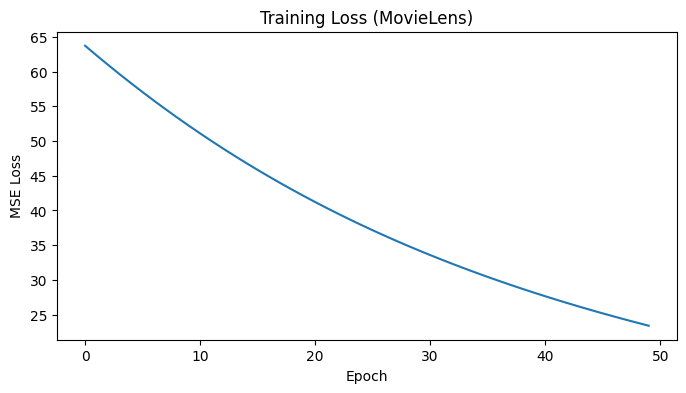


Top 5 recommendations for user ID 1:
Movie: Batman & Robin (1997) (ID: 1562), Predicted rating: 23.10
Movie: Incredible Hulk, The (2008) (ID: 60040), Predicted rating: 21.21
Movie: Anything Else (2003) (ID: 6750), Predicted rating: 21.16
Movie: Dead Meat (2004) (ID: 50613), Predicted rating: 20.91
Movie: Freshman, The (1925) (ID: 25752), Predicted rating: 20.84

Top 5 recommendations for user ID 2:
Movie: Psycho III (1986) (ID: 2903), Predicted rating: 22.13
Movie: Back to the Future Part III (1990) (ID: 2012), Predicted rating: 20.74
Movie: South Park: Imaginationland (2008) (ID: 79008), Predicted rating: 20.69
Movie: Monsters University (2013) (ID: 103141), Predicted rating: 20.41
Movie: Patti Rocks (1988) (ID: 183317), Predicted rating: 20.24

Top 5 recommendations for user ID 3:
Movie: 50 First Dates (2004) (ID: 7293), Predicted rating: 20.46
Movie: Resident Evil: Afterlife (2010) (ID: 80363), Predicted rating: 20.21
Movie: Grace of My Heart (1996) (ID: 988), Predicted rating: 20.

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import requests
import zipfile
import io

# Download and load MovieLens dataset (ml-latest-small)
url = "https://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
response = requests.get(url)
zip_file = zipfile.ZipFile(io.BytesIO(response.content))

# Extract ratings.csv
ratings_file = zip_file.open('ml-latest-small/ratings.csv')
ratings_df = pd.read_csv(ratings_file)

# Load movies.csv for movie titles
movies_file = zip_file.open('ml-latest-small/movies.csv')
movies_df = pd.DataFrame(pd.read_csv(movies_file))

# Preprocess data
# Map user and item IDs to continuous indices
user_ids = ratings_df['userId'].unique()
item_ids = ratings_df['movieId'].unique()
num_users = len(user_ids)
num_items = len(item_ids)

user_id_map = {id: idx for idx, id in enumerate(user_ids)}
item_id_map = {id: idx for idx, id in enumerate(item_ids)}

ratings_df['user_idx'] = ratings_df['userId'].map(user_id_map)
ratings_df['item_idx'] = ratings_df['movieId'].map(item_id_map)

# Split into train and test
train_df, test_df = train_test_split(ratings_df, test_size=0.2, random_state=42)

# Convert to tensors
train_users = torch.LongTensor(train_df['user_idx'].values)
train_items = torch.LongTensor(train_df['item_idx'].values)
train_ratings = torch.FloatTensor(train_df['rating'].values)

test_users = torch.LongTensor(test_df['user_idx'].values)
test_items = torch.LongTensor(test_df['item_idx'].values)
test_ratings = torch.FloatTensor(test_df['rating'].values)

# Define the Matrix Factorization model
class MatrixFactorization(nn.Module):
    def __init__(self, num_users, num_items, num_factors=50):
        super(MatrixFactorization, self).__init__()
        self.user_embeddings = nn.Embedding(num_users, num_factors)
        self.item_embeddings = nn.Embedding(num_items, num_factors)
        self.user_biases = nn.Embedding(num_users, 1)
        self.item_biases = nn.Embedding(num_items, 1)

    def forward(self, user, item):
        user_emb = self.user_embeddings(user)
        item_emb = self.item_embeddings(item)
        user_bias = self.user_biases(user).squeeze()
        item_bias = self.item_biases(item).squeeze()
        dot = torch.sum(user_emb * item_emb, dim=1)
        return dot + user_bias + item_bias

# Initialize model, loss, optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MatrixFactorization(num_users, num_items, num_factors=50).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005, weight_decay=1e-5)

# Training loop
num_epochs = 50
train_losses = []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    predictions = model(train_users.to(device), train_items.to(device))
    loss = criterion(predictions, train_ratings.to(device))
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")

# Evaluation on test set
model.eval()
with torch.no_grad():
    test_predictions = model(test_users.to(device), test_items.to(device)).cpu().numpy()
    test_rmse = np.sqrt(mean_squared_error(test_ratings.numpy(), test_predictions))
    print(f"\nTest RMSE: {test_rmse:.4f}")

# Plot training loss
plt.figure(figsize=(8, 4))
plt.plot(train_losses)
plt.title('Training Loss (MovieLens)')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.show()

# Function to get top-N recommendations for a user
def get_top_n_recommendations(user_id, n=5):
    model.eval()
    user_idx = user_id_map.get(user_id)
    if user_idx is None:
        raise ValueError(f"User ID {user_id} not found in the dataset.")

    with torch.no_grad():
        user_tensor = torch.LongTensor([user_idx]).to(device)
        all_items = torch.LongTensor(range(num_items)).to(device)
        predictions = model(user_tensor.repeat(num_items), all_items).cpu().numpy()

    # Get top N items not rated by the user
    rated_items = set(ratings_df[ratings_df['userId'] == user_id]['movieId'].values)
    item_scores = [(idx, score) for idx, score in enumerate(predictions) if item_id_map.get(movies_df.iloc[idx]['movieId']) not in rated_items]
    item_scores.sort(key=lambda x: x[1], reverse=True)
    top_n = item_scores[:n]

    # Map back to original movie IDs and get titles
    recommendations = []
    for idx, score in top_n:
        movie_id = movies_df.iloc[idx]['movieId']
        title = movies_df[movies_df['movieId'] == movie_id]['title'].values[0]
        recommendations.append((movie_id, title, score))

    return recommendations

# Get recommendations for 5 different users
user_ids_to_recommend = [1, 2, 3, 4, 5]

for user_id in user_ids_to_recommend:
    try:
        top_recommendations = get_top_n_recommendations(user_id=user_id, n=5)
        print(f"\nTop 5 recommendations for user ID {user_id}:")
        for movie_id, title, score in top_recommendations:
            print(f"Movie: {title} (ID: {movie_id}), Predicted rating: {score:.2f}")
    except ValueError as e:
        print(e)